**Dataset Reference:**

I'm using the "Sign Language MNIST" dataset, available here: [Sign Language MNIST Dataset](https://www.kaggle.com/datamunge/sign-language-mnist).

Citation:
Author(s): Takuya Kubo
Title: Sign Language MNIST
Year: 2017
URL: https://www.kaggle.com/datamunge/sign-language-mnist

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Load the dataset
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')

train_labels = train_df['label'].values
test_labels = test_df['label'].values

# Remap labels to be in the range [0, 23]
train_labels = train_labels - 1  # Subtract 1 from each label
test_labels = test_labels - 1    # Subtract 1 from each label

# Correct labels with value -1 by mapping to a valid label
train_labels[train_labels == -1] = 8  
test_labels[test_labels == -1] = 8    

# Normalize and reshape the data
train_images = (train_df.iloc[:, 1:].values / 255.0).reshape(-1, 28, 28, 1)
test_images = (test_df.iloc[:, 1:].values / 255.0).reshape(-1, 28, 28, 1)

In [3]:
unique_labels = np.unique(train_labels)
print(unique_labels)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [4]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

In [5]:
train_datagen.fit(train_images)

In [6]:
print("Shape of train_images:", train_images.shape)
print("Shape of test_images:", test_images.shape)

Shape of train_images: (27455, 28, 28, 1)
Shape of test_images: (7172, 28, 28, 1)


In [7]:
# Define the KNN classifier and train it on flattened images
knn_classifier = KNeighborsClassifier(n_neighbors=5)
train_images_flattened = train_images.reshape(train_images.shape[0], -1)
knn_classifier.fit(train_images_flattened, train_labels)

# Evaluate KNN on test data
test_images_flattened = test_images.reshape(test_images.shape[0], -1)
knn_accuracy = knn_classifier.score(test_images_flattened, test_labels)
print("KNN Accuracy:", knn_accuracy)

KNN Accuracy: 0.8060513106525377


In [8]:
# Define the CNN model
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(24, activation='softmax')  # 24 classes for A-Z
])

In [9]:
# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=1e-5),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [10]:
# Implement Early Stopping based on validation accuracy
early_stopping = EarlyStopping(
    # Monitor validation accuracy
    monitor='val_accuracy',     
    # No of epochs with no improvement after which training will stop
    patience=5,     
    # Print early stopping updates
    verbose=1,      
    # Restore the best model weights when early stopping is triggered
    restore_best_weights=True  
)

In [11]:
# Implement Model Checkpoints to save the best model 
checkpoint_path = "cnn_model.h5"
model_checkpoint = ModelCheckpoint(
    checkpoint_path, 
    # Monitor validation accuracy
    monitor='val_accuracy',  
    # Save only the best model
    save_best_only=True,     
    verbose=1
)

In [12]:
# Train the CNN model
history_cnn = cnn_model.fit(
    train_datagen.flow(train_images, train_labels, batch_size=128),
    steps_per_epoch=len(train_images) / 128,
    epochs=200,
    validation_data=(test_images, test_labels),
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/200
215/214 [==============================] - ETA: 0s - loss: 3.1756 - accuracy: 0.0431
Epoch 1: val_accuracy improved from -inf to 0.03555, saving model to cnn_model.h5
214/214 [==============================] - 26s 117ms/step - loss: 3.1756 - accuracy: 0.0431 - val_loss: 3.1740 - val_accuracy: 0.0356
Epoch 2/200


c:\Users\Xuan Min\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


215/214 [==============================] - ETA: 0s - loss: 3.1667 - accuracy: 0.0440
Epoch 2: val_accuracy improved from 0.03555 to 0.03653, saving model to cnn_model.h5
214/214 [==============================] - 29s 135ms/step - loss: 3.1667 - accuracy: 0.0440 - val_loss: 3.1671 - val_accuracy: 0.0365
Epoch 3/200
215/214 [==============================] - ETA: 0s - loss: 3.1574 - accuracy: 0.0602
Epoch 3: val_accuracy improved from 0.03653 to 0.05284, saving model to cnn_model.h5
214/214 [==============================] - 23s 106ms/step - loss: 3.1574 - accuracy: 0.0602 - val_loss: 3.1563 - val_accuracy: 0.0528
Epoch 4/200
215/214 [==============================] - ETA: 0s - loss: 3.1459 - accuracy: 0.0909
Epoch 4: val_accuracy improved from 0.05284 to 0.07153, saving model to cnn_model.h5
214/214 [==============================] - 24s 111ms/step - loss: 3.1459 - accuracy: 0.0909 - val_loss: 3.1425 - val_accuracy: 0.0715
Epoch 5/200
215/214 [==============================] - ETA: 0s -

In [13]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 64)                1

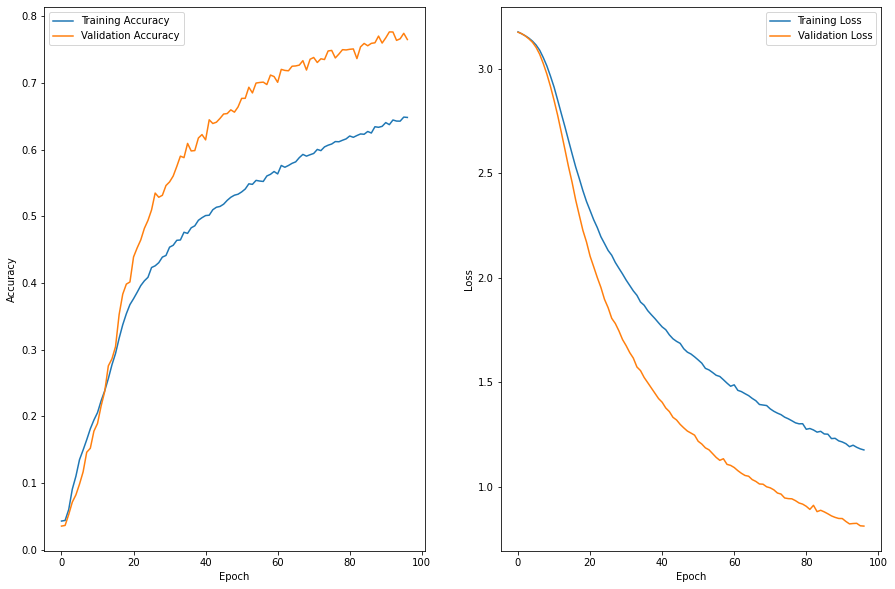

In [14]:
# Graph plot comparing Training Accuracy, Validation Accuracy, Loss, 
# and Validation Loss
plt.figure(figsize=(15, 10))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [15]:
# Make predictions on the test dataset using the trained CNN model
test_predictions_cnn = cnn_model.predict(test_images)
test_predictions_labels_cnn = np.argmax(test_predictions_cnn, axis=1)

# Print images that were recognized correctly and those that were not
for i in range(len(test_images)):
    if test_predictions_labels_cnn[i] == test_labels[i]:
        print(f"Image {i + 1}: Recognized correctly as label {test_labels[i]}")
    else:
        print(f"Image {i + 1}: Not recognized correctly. Predicted label: {test_predictions_labels_cnn[i]}, True label: {test_labels[i]}")

225/225 [==============================] - 5s 10ms/step
Image 1: Recognized correctly as label 5
Image 2: Recognized correctly as label 4
Image 3: Recognized correctly as label 9
Image 4: Recognized correctly as label 8
Image 5: Recognized correctly as label 2
Image 6: Recognized correctly as label 20
Image 7: Recognized correctly as label 9
Image 8: Recognized correctly as label 13
Image 9: Recognized correctly as label 2
Image 10: Recognized correctly as label 6
Image 11: Recognized correctly as label 7
Image 12: Recognized correctly as label 7
Image 13: Recognized correctly as label 20
Image 14: Recognized correctly as label 11
Image 15: Not recognized correctly. Predicted label: 10, True label: 6
Image 16: Recognized correctly as label 3
Image 17: Recognized correctly as label 21
Image 18: Recognized correctly as label 8
Image 19: Recognized correctly as label 6
Image 20: Recognized correctly as label 6
Image 21: Recognized correctly as label 1
Image 22: Recognized correctly as lab

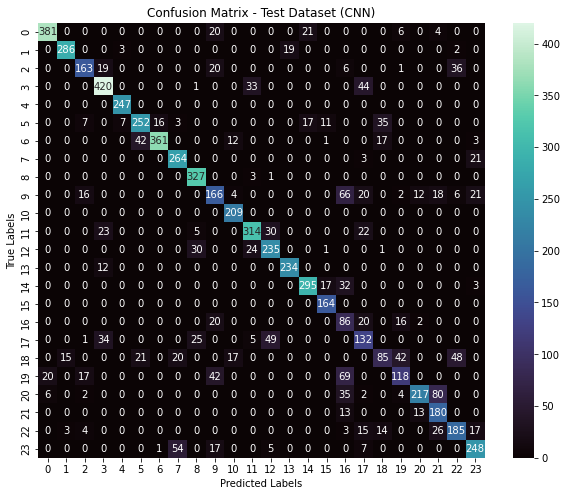

In [16]:
# Confusion Matrix for the test dataset
cm_test_cnn = confusion_matrix(test_labels, test_predictions_labels_cnn)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_test_cnn, annot=True, fmt='d', cmap=sns.color_palette("mako", as_cmap=True))
plt.title('Confusion Matrix - Test Dataset (CNN)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [17]:
# Find misclassified samples
misclassified_samples_cnn = []
for i in range(len(test_labels)):
    if test_labels[i] != test_predictions_labels_cnn[i]:
        misclassified_samples_cnn.append(i)

# Print the indices of misclassified samples
print("Misclassified Samples (Index):", misclassified_samples_cnn)

Misclassified Samples (Index): [14, 26, 29, 34, 41, 48, 52, 58, 60, 65, 66, 68, 75, 83, 88, 89, 93, 108, 110, 115, 119, 127, 128, 131, 133, 141, 143, 148, 151, 152, 153, 154, 155, 161, 163, 164, 177, 182, 194, 201, 203, 204, 207, 208, 219, 224, 231, 233, 238, 241, 242, 245, 248, 257, 259, 261, 262, 266, 267, 270, 276, 280, 284, 286, 289, 292, 294, 295, 296, 299, 303, 313, 325, 334, 339, 343, 344, 346, 354, 357, 361, 363, 365, 379, 382, 383, 389, 391, 392, 397, 399, 404, 405, 413, 414, 417, 423, 424, 425, 428, 429, 431, 442, 444, 452, 453, 454, 455, 456, 461, 468, 469, 471, 475, 476, 479, 484, 498, 513, 517, 524, 528, 529, 530, 531, 532, 533, 544, 547, 554, 564, 565, 566, 568, 571, 578, 583, 586, 595, 600, 613, 625, 627, 629, 635, 636, 642, 645, 649, 654, 662, 663, 670, 674, 678, 679, 681, 683, 686, 688, 690, 692, 693, 696, 710, 716, 727, 729, 740, 742, 746, 750, 755, 756, 758, 766, 767, 768, 769, 770, 776, 779, 780, 781, 782, 784, 785, 786, 792, 795, 796, 805, 814, 821, 824, 827, 837, 

In [18]:
# Calculate and print the loss, accuracy, precision, recall, and F1 score for the CNN model
loss_cnn, accuracy_cnn = cnn_model.evaluate(test_images, test_labels, verbose=0)
classification_report_output_cnn = classification_report(test_labels, test_predictions_labels_cnn)
classification_lines_cnn = classification_report_output_cnn.split('\n')[2:-5]
precision_cnn = []
recall_cnn = []
for line in classification_lines_cnn:
    values = line.split()
    precision_cnn.append(values[1])
    recall_cnn.append(values[2])
f1_cnn = f1_score(test_labels, test_predictions_labels_cnn, average='weighted')

print("CNN Test Loss:", loss_cnn)
print("CNN Test Accuracy:", accuracy_cnn)
print("CNN Precision:", ', '.join(precision_cnn))
print("CNN Recall:", ', '.join(recall_cnn))
print("CNN F1 Score:", f1_cnn)

CNN Test Loss: 0.8355013132095337
CNN Test Accuracy: 0.7764919400215149
CNN Precision: 0.94, 0.94, 0.78, 0.83, 0.96, 0.80, 0.96, 0.77, 0.84, 0.58, 0.86, 0.83, 0.73, 0.92, 0.89, 0.85, 0.28, 0.50, 0.56, 0.62, 0.89, 0.58, 0.67, 0.79
CNN Recall: 0.88, 0.92, 0.67, 0.84, 1.00, 0.72, 0.83, 0.92, 0.99, 0.50, 1.00, 0.80, 0.81, 0.95, 0.85, 1.00, 0.60, 0.54, 0.34, 0.44, 0.63, 0.87, 0.69, 0.75
CNN F1 Score: 0.7762847677451937
